In [1]:

# For local testing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
# Metrics、Plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.random.set_seed(42)
np.random.seed(42)

2025-04-13 19:59:27.365473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744588768.347538    1970 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744588768.618507    1970 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744588771.100270    1970 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744588771.100297    1970 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744588771.100299    1970 computation_placer.cc:177] computation placer alr

In [2]:
data_folder = pathlib.Path('./dataset/')

### Split train, validation, and test

In [ ]:
# Load training and validation datasets (split 20% from the train folder as the validation set)
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    color_mode='grayscale',
    image_size=(96, 96),  # Resize to 96x96 to fit MobileNetV2
    batch_size=32,
    shuffle=True,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=42
)

val_dataset = image_dataset_from_directory(
    data_folder / "train",
    color_mode='grayscale',
    image_size=(96, 96),
    batch_size=32,
    shuffle=True,
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=42
)

test_dataset = image_dataset_from_directory(
    data_folder / "test",
    color_mode='grayscale',
    image_size=(96, 96),
    batch_size=32,
    shuffle=False,
    label_mode='categorical'
)

class_names = train_dataset.class_names
print("Class names:", class_names)

# Define a function to convert grayscale images to RGB (duplicate the single channel to three channels)
def grayscale_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale image to RGB
    return image, label

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


I0000 00:00:1744588847.751482    1970 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Normalization and Caching

In [ ]:
# Apply transformations
train_dataset = train_dataset.map(grayscale_to_rgb)
val_dataset = val_dataset.map(grayscale_to_rgb)
test_dataset = test_dataset.map(grayscale_to_rgb)

# Normalize image pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])
train_dataset_augmentation = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Optimize data loading
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset_augmentation = train_dataset_augmentation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Use pre-train model MobileNetV2

In [ ]:
# Construct MobileNetV2 model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load MobileNetV2 model (excluding the top fully connected layers, using pre-trained weights)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
# Freeze the pre-trained layers of MobileNetV2
base_model.trainable = False

# Build the model
inputs = layers.Input(shape=(96, 96, 3))
x = base_model(inputs, training=False)  # Use MobileNetV2 for feature extraction
x = layers.GlobalAveragePooling2D()(x)  # Global average pooling to reduce parameter count
x = layers.Dense(256, activation='relu')(x)  # Fully connected layer
x = layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
outputs = layers.Dense(len(class_names), activation='softmax')(x)  # Output layer for 7 classes

# Create the model
model_mobilenetv2 = models.Model(inputs, outputs)

# Compile the model (using a smaller learning rate for transfer learning)
model_mobilenetv2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Smaller learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model structure
model_mobilenetv2.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Training

In [ ]:
# Set up callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="./models/best_mobilenet_model.keras",
        save_best_only=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

# Train the model
history_mobilenetv2 = model_mobilenetv2.fit(
    train_dataset_augmentation,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/30


I0000 00:00:1744588875.493504    4595 service.cc:152] XLA service 0x7f77bc001b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744588875.493535    4595 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
I0000 00:00:1744588877.065655    4595 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/718 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.1586 - loss: 3.0234 

I0000 00:00:1744588886.063154    4595 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


718/718 ━━━━━━━━━━━━━━━━━━━━ 75s 85ms/step - accuracy: 0.2606 - loss: 2.0030 - val_accuracy: 0.3566 - val_loss: 1.6388
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3511 - loss: 1.6468 - val_accuracy: 0.3681 - val_loss: 1.6069
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3734 - loss: 1.5971 - val_accuracy: 0.3850 - val_loss: 1.5691
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3941 - loss: 1.5595 - val_accuracy: 0.3954 - val_loss: 1.5570
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4014 - loss: 1.5339 - val_accuracy: 0.3928 - val_loss: 1.5516
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4180 - loss: 1.5066 - val_accuracy: 0.4041 - val_loss: 1.5308
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4252 - loss: 1.4817 - val_accuracy: 0.4048 - val_loss: 1.5226
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4388 - loss: 1.4600 - val_accuracy: 0.4053

#### Plotting

225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.3689 - loss: 1.5984
Test Loss: 1.4908373355865479
Test Accuracy: 0.42337697744369507
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
Confusion Matrix (Test Set):
 [[ 249    0  105  285  171  104   44]
 [  17    0   15   46   18   14    1]
 [ 135    0  232  225  178  129  125]
 [  78    0   68 1317  203   59   49]
 [  93    0  112  324  521  109   74]
 [ 194    0  130  360  271  241   51]
 [  45    0  105   99   84   19  479]]


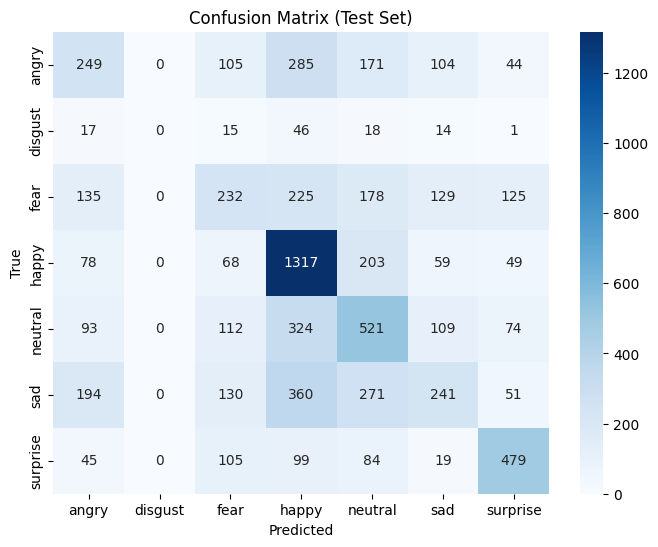

/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

Classification Report (Test Set):
               precision    recall  f1-score   support

       angry       0.31      0.26      0.28       958
     disgust       0.00      0.00      0.00       111
        fear       0.30      0.23      0.26      1024
       happy       0.50      0.74      0.59      1774
     neutral       0.36      0.42      0.39      1233
         sad       0.36      0.19      0.25      1247
    surprise       0.58      0.58      0.58       831

    accuracy                           0.42      7178
   macro avg       0.34      0.35      0.34      7178
weighted avg       0.40      0.42      0.40      7178



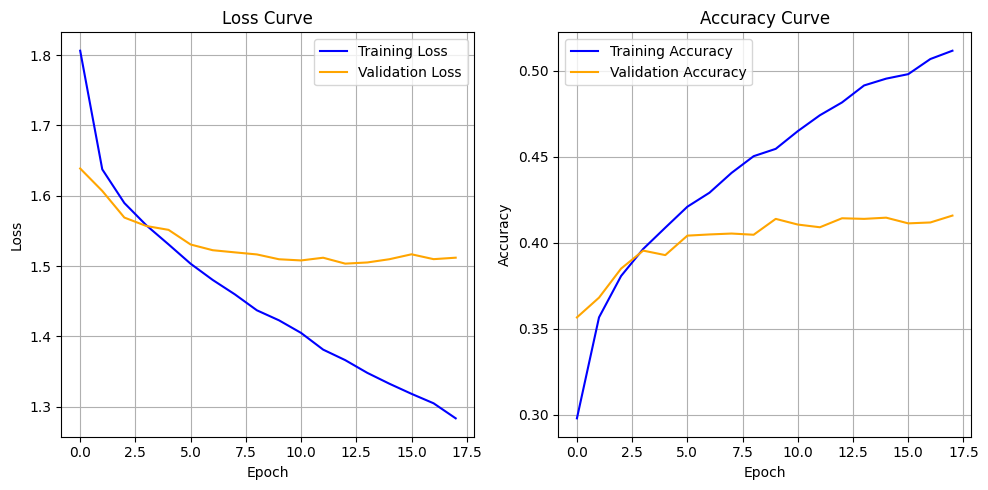

In [ ]:
def plot_training_history(history, model):
    # Final evaluation: Calculate accuracy and loss on the test set
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_acc}")

    # Confusion matrix and classification report (using test_dataset)
    # Get true labels
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_true = np.argmax(y_true, axis=1)

    # Predict labels
    y_pred = model.predict(test_dataset)
    y_pred = np.argmax(y_pred, axis=1)

    # Check if shapes match
    if len(y_true) != len(y_pred):
        raise ValueError(f"Mismatch between y_true ({len(y_true)}) and y_pred ({len(y_pred)}) lengths!")

    # Print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix (Test Set):\n", cm)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print("Classification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))

    # Plot training curves (unchanged)
    plt.figure(figsize=(10, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history_mobilenetv2, model_mobilenetv2)